In [122]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import os
from pathlib import Path
import numpy as np
import pandas as pd
from scipy.signal import welch
from scipy.stats import kurtosis, skew

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cross_decomposition import CCA


from tqdm import tqdm, trange

import warnings
from sklearn.exceptions import ConvergenceWarning

from PyEMD import EMD

import antropy as ant
import random


In [123]:
torch.cuda.empty_cache()




In [124]:
from scipy.signal import welch
import numpy as np

def compute_bandpower(data, fs, band):
    freqs, psd = welch(data, fs=fs, nperseg=fs//2)
    idx_band = np.logical_and(freqs >= band[0], freqs <= band[1])
    return np.trapz(psd[idx_band], freqs[idx_band])

def compute_rms(x):
    return np.sqrt(np.mean(np.square(x)))

def compute_hjorth_params(x):
    first_deriv = np.diff(x)
    second_deriv = np.diff(first_deriv)

    var_zero = np.var(x)
    var_d1 = np.var(first_deriv)
    var_d2 = np.var(second_deriv)

    mobility = np.sqrt(var_d1 / var_zero) if var_zero != 0 else 0
    complexity = np.sqrt(var_d2 / var_d1) if var_d1 != 0 else 0

    return mobility, complexity

In [140]:
def normalize_signal(signal):
    max_abs = np.max(np.abs(signal))
    return signal / max_abs if max_abs != 0 else signal

class EEGWindowDataset(Dataset):
    def __init__(self, combined_data_path, training_data_path, sampling_rate=250, window_sec=2):
        self.combined_data = pd.read_csv(combined_data_path).values.astype(np.float32)
        self.training_data = pd.read_csv(training_data_path).values.astype(np.int64)

        self.window_size = int(window_sec * sampling_rate)
        self.half_window = self.window_size // 2

        self.total_rows = self.combined_data.shape[0]
        self.sampling_rate = sampling_rate

    def __len__(self):
        return len(self.training_data)

    def __getitem__(self, idx):
        class_label, center_idx = self.training_data[idx]

        # Define full 2-second window
        max_shift = int(0.5 * self.sampling_rate)  # 125 if sampling_rate = 250
        random_shift = random.randint(-max_shift, max_shift)
        
        center_idx += random_shift
        
        start_idx = center_idx - self.half_window
        end_idx = center_idx + self.half_window

        # Edge padding if needed
        if start_idx < 0 or end_idx > self.total_rows:
            window = np.zeros((self.window_size, 4), dtype=np.float32)
            actual_start = max(0, start_idx)
            actual_end = min(self.total_rows, end_idx)
            window_offset_start = max(0, -start_idx)
            window[window_offset_start:window_offset_start + (actual_end - actual_start)] = \
                self.combined_data[actual_start:actual_end, :4]
        else:
            window = self.combined_data[start_idx:end_idx, :4]

        # Split window into 4 segments (0.5s each @ 250 Hz = 125 samples)
        segment_size = self.window_size // 4  # 0.5 seconds = 125 samples
        features_per_segment = []
        
        #max_abs = np.max(np.abs(window))
        #window = window / max_abs if max_abs != 0 else window

        for i in range(4):  # 4 segments
            segment = window[i * segment_size: (i + 1) * segment_size, :]
            segment_features = []

            for ch in range(4):  # 4 channels
                signal = segment[:, ch]

                alpha = compute_bandpower(signal, fs=self.sampling_rate, band=(8, 13))
                beta = compute_bandpower(signal, fs=self.sampling_rate, band=(13, 30))
                rms = compute_rms(signal)
                mobility, complexity = compute_hjorth_params(signal)
                #skewness = skew(signal)
                #sampen = ant.sample_entropy(signal, order=2, metric='chebyshev')
                #kurt = kurtosis(signal, fisher=True, bias=False)
                

                segment_features.extend([alpha, beta, mobility, rms, complexity])
                
            segment_features = np.array(segment_features, dtype=np.float32)
                
            mu = np.mean(segment_features)
            sigma = np.std(segment_features)
            segment_features = (segment_features - mu) / sigma if sigma != 0 else segment_features

            features_per_segment.append(segment_features)  # shape: (20,)
        
        features_per_segment = np.array(features_per_segment, dtype=np.float32)  # ✅ efficient conversion
        feature_tensor = torch.tensor(features_per_segment, dtype=torch.float32)  # shape: (4, 20)
        return feature_tensor, class_label

# Model

In [141]:
class EEG_BiLSTMClassifier(nn.Module):
    def __init__(self, input_size=32, hidden_size=32, num_layers=2, num_classes=11, dropout=0.3):
        super(EEG_BiLSTMClassifier, self).__init__()

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=True  # ✅ BiLSTM enabled
        )

        # Note: hidden_size is doubled because it's bidirectional
        self.fc = nn.Sequential(
            nn.Linear(hidden_size * 2, 32),  # ✅ multiply by 2
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        # x: (batch_size, time_steps, features)
        lstm_out, _ = self.lstm(x)  # shape: (batch, time_steps, hidden_size * 2)

        # Take output from last time step
        last_output = lstm_out[:, -1, :]  # shape: (batch, hidden_size * 2)

        out = self.fc(last_output)  # shape: (batch, num_classes)
        return out


In [142]:
class EEG_LSTMClassifier(nn.Module):
    def __init__(self, input_size=20, hidden_size=32, num_layers=2, num_classes=11, dropout=0.3):
        super(EEG_LSTMClassifier, self).__init__()

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        # x: (batch_size, time_steps, features)
        lstm_out, _ = self.lstm(x)  # lstm_out: (batch, time_steps, hidden_size)
        
        # Take the output from the last time step
        last_output = lstm_out[:, -1, :]  # shape: (batch_size, hidden_size)

        out = self.fc(last_output)  # shape: (batch_size, num_classes)
        return out

In [143]:
def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=30, device='cuda'):
    model.to(device)
    count = 0
    epoch_bar = trange(num_epochs, desc="Training Epochs", unit="epoch")
    
    for epoch in epoch_bar:
        # -------- Training Phase --------
        model.train()
        total_loss = 0
        
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_X)

            # Compute individual losses
            criterion = nn.CrossEntropyLoss(reduction='none')
            losses = criterion(outputs, batch_y)  # shape: (batch_size,)

            loss = losses.mean()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)

        # Update progress bar with loss
        epoch_bar.set_description(f"Epoch {epoch+1}/{num_epochs}")
        epoch_bar.set_postfix(loss=avg_loss)

    # -------- Validation Phase (at end of training) --------
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for val_X, val_y in val_loader:
            val_X, val_y = val_X.to(device), val_y.to(device)
            outputs = model(val_X)
            preds = torch.argmax(outputs, dim=1)

            y_true.extend(val_y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    val_accuracy = accuracy_score(y_true, y_pred)

    print("\nConfusion Matrix:\n", cm)
    print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=3))
    
    return val_accuracy, avg_loss, cm



## Window Size Optimization

Using device: cuda
Training for Window Size: 2


Training Epochs:   0%|                                                                       | 0/30 [00:00<?, ?epoch/s]C:\Users\shawn\AppData\Local\Temp\ipykernel_29164\839894693.py:75: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  feature_tensor = torch.tensor(features_per_segment, dtype=torch.float32)  # shape: (4, 20)
Epoch 30/30: 100%|███████████████████████████████████████████████████████| 30/30 [03:04<00:00,  6.14s/epoch, loss=1.53]



Confusion Matrix:
 [[10  1  7  0  0  0  0  1  0  0  0]
 [ 0  7 10  0  0  2  0  0  0  2  0]
 [ 0  7  5  0  0  3  0  0  0  4  0]
 [ 0  0  0  9  0  1  3  1  1  0  0]
 [ 0  0  0 11  0  2  8  0  1  0  0]
 [ 0  0  0  1  0 10  4  0  0  1  0]
 [ 0  0  0  6  0  5  6  0  0  0  0]
 [ 2  0  0  4  0  1  8  6  1  0  0]
 [ 0  0  0  5  0  0  7  7  2  0  0]
 [ 0  2  0  0  0  0  0  0  0 15  2]
 [ 0  0  0  0  1  0  0  0  0 12  0]]

Classification Report:
               precision    recall  f1-score   support

           0      0.833     0.526     0.645        19
           1      0.412     0.333     0.368        21
           2      0.227     0.263     0.244        19
           3      0.250     0.600     0.353        15
           4      0.000     0.000     0.000        22
           5      0.417     0.625     0.500        16
           6      0.167     0.353     0.226        17
           7      0.400     0.273     0.324        22
           8      0.400     0.095     0.154        21
           9     

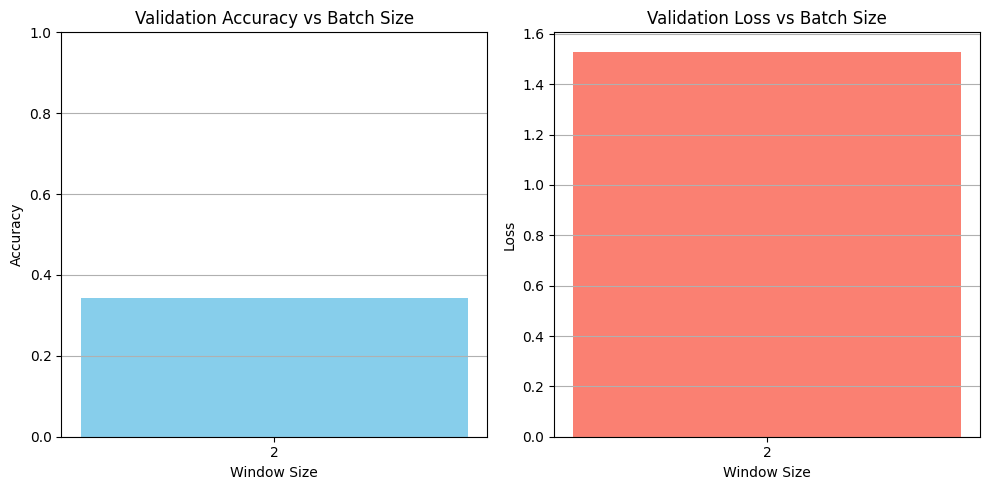

In [144]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

window_sizes = [2]
cm_array = []
accuracies = []
losses = []

for window_size in window_sizes:
    print("Training for Window Size:", window_size)

    model = EEG_LSTMClassifier()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    #criterion = nn.CrossEntropyLoss(reduction='none')
    criterion = nn.CrossEntropyLoss()

    
    training_dataset = EEGWindowDataset("ShawnTrainingData/combined_data.csv", "ShawnTrainingData/training_data.csv", sampling_rate=250, window_sec=window_size)
    testing_dataset = EEGWindowDataset("ShawnTrainingData/combined_data.csv", "ShawnTrainingData/testing_data.csv", sampling_rate=250, window_sec=window_size)

    train_loader = DataLoader(training_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(testing_dataset, batch_size=64, shuffle=False)

    acc, loss, cm = train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=30, device=device)
    cm_array.append(cm)
    accuracies.append(acc)
    losses.append(loss)

plt.figure(figsize=(10, 5))

# Accuracy bar plot
plt.subplot(1, 2, 1)
plt.bar([str(bs) for bs in window_sizes], accuracies, color='skyblue')
plt.title("Validation Accuracy vs Batch Size")
plt.xlabel("Window Size")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True, axis='y')

# Loss bar plot
plt.subplot(1, 2, 2)
plt.bar([str(bs) for bs in window_sizes], losses, color='salmon')
plt.title("Validation Loss vs Batch Size")
plt.xlabel("Window Size")
plt.ylabel("Loss")
plt.grid(True, axis='y')

plt.tight_layout()
plt.show()

In [83]:
torch.save(model.state_dict(), "model.pth")

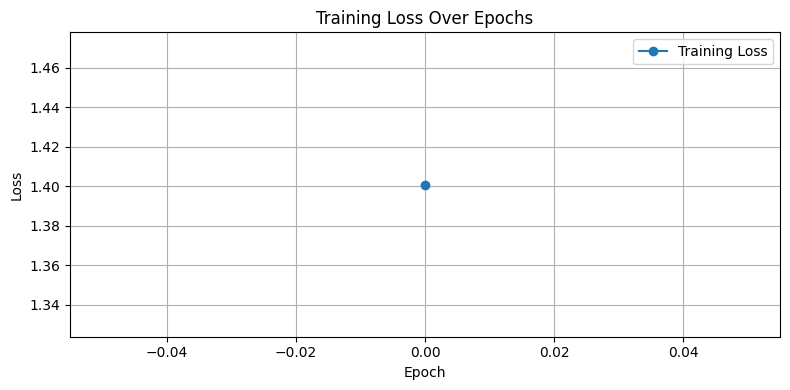

In [120]:
plt.figure(figsize=(8, 4))
plt.plot(losses, marker='o', label='Training Loss')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [145]:
for i in range(len(cm_array)):
    print(cm_array[i])
    print("Accuracy: ", accuracies[i])
    print("Loss: ", losses[i])

[[10  1  7  0  0  0  0  1  0  0  0]
 [ 0  7 10  0  0  2  0  0  0  2  0]
 [ 0  7  5  0  0  3  0  0  0  4  0]
 [ 0  0  0  9  0  1  3  1  1  0  0]
 [ 0  0  0 11  0  2  8  0  1  0  0]
 [ 0  0  0  1  0 10  4  0  0  1  0]
 [ 0  0  0  6  0  5  6  0  0  0  0]
 [ 2  0  0  4  0  1  8  6  1  0  0]
 [ 0  0  0  5  0  0  7  7  2  0  0]
 [ 0  2  0  0  0  0  0  0  0 15  2]
 [ 0  0  0  0  1  0  0  0  0 12  0]]
Accuracy:  0.3431372549019608
Loss:  1.5297337495363676


## Batch Size Optimization

Training for Batch Size: 8


Training Epochs:  97%|███████████████████████████████████████████████████████████▉  | 29/30 [00:53<00:01,  1.81s/epoch]C:\Users\shawn\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shawn\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shawn\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted

Confusion Matrix:
[[ 4  3  1  0  0  0  0  0  1  0  2]
 [ 1 13  2  0  0  0  0  0  0  2  1]
 [ 0 13  4  0  0  0  0  0  0  4  2]
 [ 1 12  3  0  0  0  0  0  3  0  0]
 [ 0  8  4  0  0  0  0  0  0  0  0]
 [ 0 12  3  0  0  0  0  0  6  0  0]
 [ 1  9  4  0  0  0  0  0  6  0  0]
 [ 0  5  2  0  0  0  0  0 10  0  0]
 [ 0  4  2  0  0  0  0  0 15  0  0]
 [ 1  0  0  0  0  0  0  0  0 14  4]
 [ 0  1  0  0  0  0  0  0  0  6  7]]

Classification Report:
              precision    recall  f1-score   support

           0      0.500     0.364     0.421        11
           1      0.163     0.684     0.263        19
           2      0.160     0.174     0.167        23
           3      0.000     0.000     0.000        19
           4      0.000     0.000     0.000        12
           5      0.000     0.000     0.000        21
           6      0.000     0.000     0.000        20
           7      0.000     0.000     0.000        17
           8      0.366     0.714     0.484        21
           9      0.

Training Epochs:  97%|███████████████████████████████████████████████████████████▉  | 29/30 [00:49<00:01,  1.69s/epoch]C:\Users\shawn\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shawn\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shawn\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted

Confusion Matrix:
[[ 0  2  4  0  0  0  0  3  0  0  2]
 [ 0  6 10  0  0  0  0  1  0  1  1]
 [ 0  6 12  0  0  0  0  0  0  3  2]
 [ 0  2  0  0  2 15  0  0  0  0  0]
 [ 0  1  0  0  1 10  0  0  0  0  0]
 [ 0  0  0  0  3 18  0  0  0  0  0]
 [ 0  0  1  0  1 18  0  0  0  0  0]
 [ 0  0  0  0  0  9  0  8  0  0  0]
 [ 0  1  1  0  2  9  0  8  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 15  4]
 [ 0  0  0  0  0  1  0  0  0  6  7]]

Classification Report:
              precision    recall  f1-score   support

           0      0.000     0.000     0.000        11
           1      0.333     0.316     0.324        19
           2      0.429     0.522     0.471        23
           3      0.000     0.000     0.000        19
           4      0.111     0.083     0.095        12
           5      0.225     0.857     0.356        21
           6      0.000     0.000     0.000        20
           7      0.400     0.471     0.432        17
           8      0.000     0.000     0.000        21
           9      0.

Training Epochs:  97%|███████████████████████████████████████████████████████████▉  | 29/30 [00:47<00:01,  1.64s/epoch]C:\Users\shawn\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shawn\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shawn\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted

Confusion Matrix:
[[ 0  0  4  2  0  0  0  3  0  1  1]
 [ 0  6 10  0  0  0  0  1  0  2  0]
 [ 0  5 11  1  0  0  0  1  0  3  2]
 [ 0  1  0 17  0  0  0  1  0  0  0]
 [ 0  2  0 10  0  0  0  0  0  0  0]
 [ 0  0  0 14  0  0  0  7  0  0  0]
 [ 0  0  0 12  0  0  0  8  0  0  0]
 [ 0  0  0  5  0  0  0 12  0  0  0]
 [ 0  0  0  6  0  0  0 15  0  0  0]
 [ 0  0  1  0  0  0  0  1  0 13  4]
 [ 0  0  0  1  0  0  0  0  0  7  6]]

Classification Report:
              precision    recall  f1-score   support

           0      0.000     0.000     0.000        11
           1      0.429     0.316     0.364        19
           2      0.423     0.478     0.449        23
           3      0.250     0.895     0.391        19
           4      0.000     0.000     0.000        12
           5      0.000     0.000     0.000        21
           6      0.000     0.000     0.000        20
           7      0.245     0.706     0.364        17
           8      0.000     0.000     0.000        21
           9      0.

Training Epochs:  97%|███████████████████████████████████████████████████████████▉  | 29/30 [00:49<00:01,  1.92s/epoch]C:\Users\shawn\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shawn\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shawn\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted

Confusion Matrix:
[[ 0  0  4  0  0  0  0  4  0  0  3]
 [ 0  0 16  0  0  0  0  1  0  2  0]
 [ 0  0 17  0  2  0  0  0  0  2  2]
 [ 0  0  1  0 16  0  0  2  0  0  0]
 [ 0  0  1  0  9  0  0  2  0  0  0]
 [ 0  0  0  0 15  0  0  6  0  0  0]
 [ 0  0  0  0 14  0  0  5  0  0  1]
 [ 0  0  0  0  5  0  0 12  0  0  0]
 [ 0  0  0  0  6  0  0 15  0  0  0]
 [ 0  0  3  0  0  0  0  0  0 11  5]
 [ 0  0  1  0  1  0  0  0  0  6  6]]

Classification Report:
              precision    recall  f1-score   support

           0      0.000     0.000     0.000        11
           1      0.000     0.000     0.000        19
           2      0.395     0.739     0.515        23
           3      0.000     0.000     0.000        19
           4      0.132     0.750     0.225        12
           5      0.000     0.000     0.000        21
           6      0.000     0.000     0.000        20
           7      0.255     0.706     0.375        17
           8      0.000     0.000     0.000        21
           9      0.

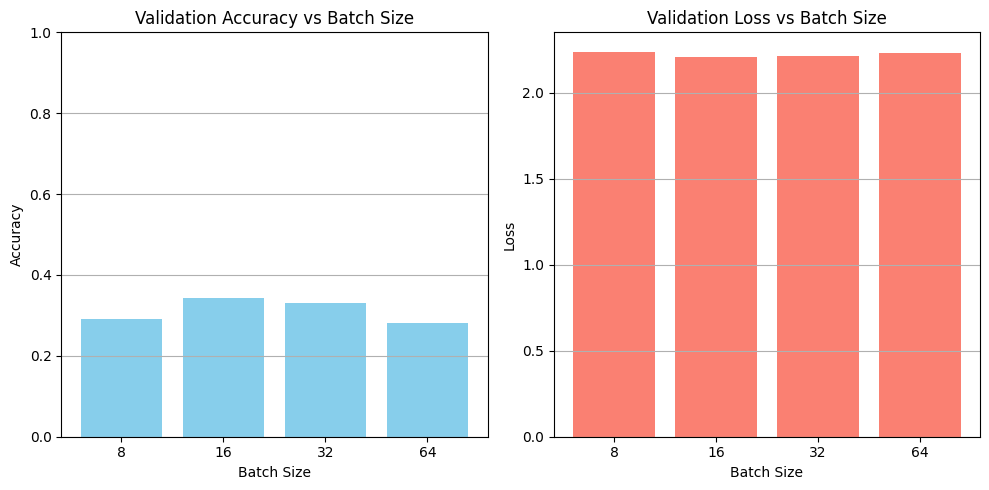

In [8]:
batch_sizes = [8, 16,32,64]
accuracies = []
losses = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

for batch_size in batch_sizes:
    print("Training for Batch Size:", batch_size)

    model = EEGClassifier()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(testing_dataset, batch_size=batch_size, shuffle=False)

    acc, loss, cm = train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=30, device=device)
    accuracies.append(acc)
    losses.append(loss)

plt.figure(figsize=(10, 5))

# Accuracy bar plot
plt.subplot(1, 2, 1)
plt.bar([str(bs) for bs in batch_sizes], accuracies, color='skyblue')
plt.title("Validation Accuracy vs Batch Size")
plt.xlabel("Batch Size")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True, axis='y')

# Loss bar plot
plt.subplot(1, 2, 2)
plt.bar([str(bs) for bs in batch_sizes], losses, color='salmon')
plt.title("Validation Loss vs Batch Size")
plt.xlabel("Batch Size")
plt.ylabel("Loss")
plt.grid(True, axis='y')

plt.tight_layout()
plt.show()